# Code taken from https://github.com/ngaggion/Chest-xray-landmark-dataset


In [111]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
import re

def preprocess(folderpath, flist):
    try:
        os.mkdir(folderpath)
        print(f"Created directory: {folderpath}")
    except FileExistsError:
        print(f"Directory already exists: {folderpath}")
    
    for f in flist:
        w, h = 2048, 2048
        
        try:
            with open(f, 'rb') as path:
                dtype = np.dtype('>u2')
                img = np.fromfile(path, dtype=dtype).reshape((h, w))
            
            # Preprocess the image
            img = 1 - img.astype('float') / 4096
            img = cv2.resize(img, (1024, 1024))
            img = img * 255
            
            # Ensure the image data is within valid range and type
            img = np.clip(img, 0, 255).astype('uint8')
            
            p = os.path.join(folderpath, os.path.basename(f).replace('.IMG', '.png'))
            
            # Write the image and check for success
            if cv2.imwrite(p, img):
                print(f"Saved image to: {p}")
            else:
                print(f"Failed to save image to: {p}")
        except Exception as e:
            print(f"Failed to process file {f}: {e}")

In [112]:
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

img_path = "All247images"

data_root = pathlib.Path(img_path)
all_files = list(data_root.glob('*.IMG'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

save_path = "All247imagesPNG/"
# preprocess(save_path, all_files)

In [113]:
def draw_organ(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x, y = array[i,:]
        circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(RL, LL, H = None, RCLA = None, LCLA = None, img =  None):

    fig, ax = plt.subplots()
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        img = np.zeros([1024, 1024])
        plt.imshow(img)
    
    plt.axis('off')
    
    draw_lines(ax, RL, 'g')
    draw_lines(ax, LL, 'g')
    
    draw_organ(ax, RL, 'g')
    draw_organ(ax, LL, 'g')
    
    if H is not None:
        draw_lines(ax, H, 'b')
        draw_organ(ax, H, 'b')

    if RCLA is not None:
        draw_lines(ax, RCLA)
        draw_organ(ax, RCLA)
    
    if RCLA is not None:
        draw_lines(ax, LCLA)
        draw_organ(ax, LCLA)

    return

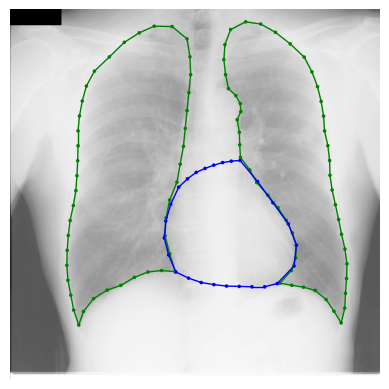

In [117]:
data_root = pathlib.Path("All247imagesPNG/")
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

img1 = all_files[0]
RL = img1.replace('All247imagesPNG','landmarks/RL').replace('.png','.npy')
LL = img1.replace('All247imagesPNG','landmarks/LL').replace('.png','.npy')
H = img1.replace('All247imagesPNG','landmarks/H').replace('.png','.npy')

img = cv2.imread(img1,0)
RL = np.load(RL)
LL = np.load(LL)
H = np.load(H)

drawOrgans(RL,LL,H,img=img)

Text(0.5, 1.0, '(1024, 1024, 3)')

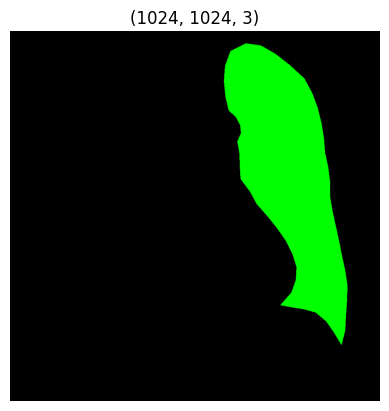

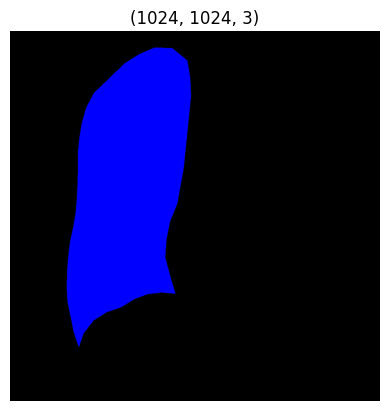

In [134]:
def getDenseMaskRightLungs(LL):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    img[:, :, :] = 0  # Set the red channel to 255 for the background

    LL = LL.reshape(-1, 1, 2).astype('int')
    img = cv2.drawContours(img, [LL], -1, (0, 255, 0), -1)

    return img

plt.figure()
aux = getDenseMaskRightLungs(LL)
plt.imshow(aux)
plt.axis(False)
plt.title(aux.shape)

def getDenseMaskLeftLungs(RL):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    img[:, :, :] = 0  # Set the red channel to 255 for the background
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    img = cv2.drawContours(img, [RL], -1, (0, 0, 255), -1)

    return img

plt.figure()
aux = getDenseMaskLeftLungs(RL)
plt.imshow(aux)
plt.axis(False)
plt.title(aux.shape)

Text(0.5, 1.0, '(1024, 1024, 3)')

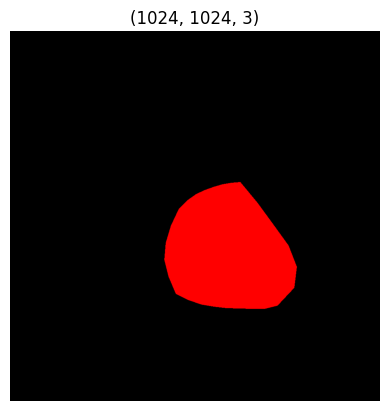

In [136]:
def getDenseMaskHeart(H):
    # Create an RGB image with a red background
    img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    img[:, :, :] = 0  # Set the red channel to 255 for the background
        
    H = H.reshape(-1, 1, 2).astype('int')
    img = cv2.drawContours(img, [H], -1, (255,  0, 0), -1)

    return img

plt.figure()
aux = getDenseMaskHeart(H)
plt.imshow(aux)
plt.axis(False)
plt.title(aux.shape)


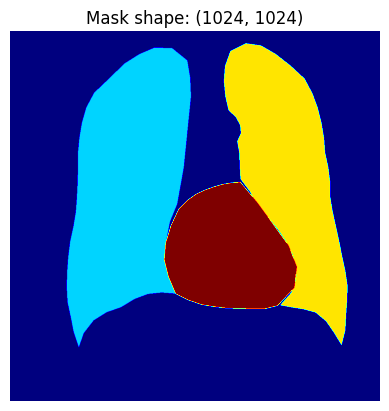

In [121]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def getDenseMaskLungs(RL, LL, H):
    # Create a single-channel image for the mask
    mask = np.zeros((1024, 1024), dtype=np.uint8)
    
    # Reshape the contours
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    # Draw each contour with a unique value
    mask = cv2.drawContours(mask, [RL], -1, 1, -1)  # Right lung with value 1
    mask = cv2.drawContours(mask, [LL], -1, 2, -1)  # Left lung with value 2
    mask = cv2.drawContours(mask, [H], -1, 3, -1)   # Heart with value 3

    return mask
  
plt.figure()
aux = getDenseMaskLungs(RL, LL, H)
plt.imshow(aux, cmap='jet')  # Use 'jet' colormap to visualize different regions
plt.axis('off')
plt.title(f'Mask shape: {aux.shape}')
plt.show()


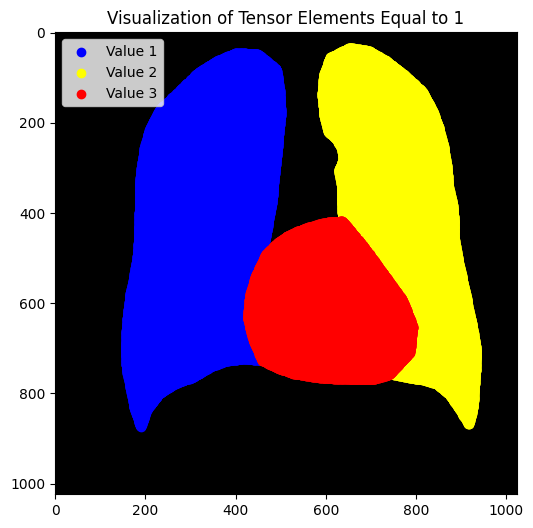

In [122]:
coords_1 = np.column_stack(np.where(aux == 1))
coords_2 = np.column_stack(np.where(aux == 2))
coords_3 = np.column_stack(np.where(aux == 3))

plt.figure(figsize=(6, 6))
plt.imshow(aux, cmap='gray', interpolation='none')
plt.scatter(coords_1[:, 1], coords_1[:, 0], color='blue', marker='o', label='Value 1')
plt.scatter(coords_2[:, 1], coords_2[:, 0], color='yellow', marker='o', label='Value 2')
plt.scatter(coords_3[:, 1], coords_3[:, 0], color='red', marker='o', label='Value 3')
plt.legend()
plt.title('Visualization of Tensor Elements Equal to 1')
plt.show()

In [54]:
cv2.imwrite('mask.png', aux)

True

(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

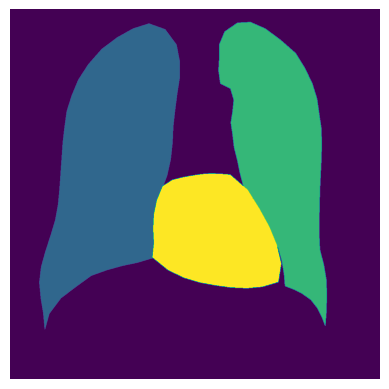

In [71]:
from PIL import Image

image = cv2.imread('mask.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

plt.imshow(image)
plt.axis(False)

In [137]:
def process_and_save_images(input_folder, output_folder, heart_folder='heart', left_lung_folder='left_lungs', right_lung_folder='right_lungs'):
    data_root = pathlib.Path(input_folder)
    all_files = list(data_root.glob('*.png'))
    all_files = [str(path) for path in all_files]
    all_files.sort(key=natural_key)
    

    heart_output_path = os.path.join(output_folder, heart_folder)
    left_output_path = os.path.join(output_folder, left_lung_folder)
    right_output_path = os.path.join(output_folder, right_lung_folder)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    if not os.path.exists(heart_output_path):
        os.makedirs(heart_output_path)
    if not os.path.exists(left_output_path):
        os.makedirs(left_output_path)
    if not os.path.exists(right_output_path):
        os.makedirs(right_output_path)

    for file_path in all_files:
        file_name = os.path.basename(file_path)
        base_name = os.path.splitext(file_name)[0]

        RL_path = file_path.replace('All247imagesPNG', 'landmarks/RL').replace('.png', '.npy')
        LL_path = file_path.replace('All247imagesPNG', 'landmarks/LL').replace('.png', '.npy')
        H_path = file_path.replace('All247imagesPNG', 'landmarks/H').replace('.png', '.npy')
        
        img = cv2.imread(file_path, 0)
        RL = np.load(RL_path)
        LL = np.load(LL_path)
        H = np.load(H_path)
        
        left_mask = getDenseMaskLeftLungs(RL)
        right_mask = getDenseMaskRightLungs(LL)
        heart_mask = getDenseMaskHeart(H)
        
        heart_path = os.path.join(heart_output_path, file_name)
        left_path = os.path.join(left_output_path, file_name)
        right_path = os.path.join(right_output_path, file_name)
        
        cv2.imwrite(heart_path, heart_mask)
        cv2.imwrite(left_path, left_mask)
        cv2.imwrite(right_path, right_mask)
        
        print(f"Saved masked image to: {heart_path}, {left_path}, {right_path}")

In [138]:
input_folder = "All247imagesPNG"
output_folder = "All247masks"

process_and_save_images(input_folder, output_folder)

Saved masked image to: All247masks\heart\JPCLN001.png, All247masks\left_lungs\JPCLN001.png, All247masks\right_lungs\JPCLN001.png
Saved masked image to: All247masks\heart\JPCLN002.png, All247masks\left_lungs\JPCLN002.png, All247masks\right_lungs\JPCLN002.png
Saved masked image to: All247masks\heart\JPCLN003.png, All247masks\left_lungs\JPCLN003.png, All247masks\right_lungs\JPCLN003.png
Saved masked image to: All247masks\heart\JPCLN004.png, All247masks\left_lungs\JPCLN004.png, All247masks\right_lungs\JPCLN004.png
Saved masked image to: All247masks\heart\JPCLN005.png, All247masks\left_lungs\JPCLN005.png, All247masks\right_lungs\JPCLN005.png
Saved masked image to: All247masks\heart\JPCLN006.png, All247masks\left_lungs\JPCLN006.png, All247masks\right_lungs\JPCLN006.png
Saved masked image to: All247masks\heart\JPCLN007.png, All247masks\left_lungs\JPCLN007.png, All247masks\right_lungs\JPCLN007.png
Saved masked image to: All247masks\heart\JPCLN008.png, All247masks\left_lungs\JPCLN008.png, All24

# Preprocess The Data


### According to the paper

- Each image in these datasets was preprocessed with
  the following operations, performed in sequence: normalization to the range [0,1]; resized to size (224, 224); histogram
  equalization


In [2]:
import os
import cv2
import numpy as np
from glob import glob

def load_images_from_folder(folder):
    images = []
    for filename in glob(os.path.join(folder, '*.png')):
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def preprocess_image(image):
    
    # Normalize the image to range [0, 1]
    normalized_image = image / 255.0
    
    # Resize the image to 224x224
    resized_image = cv2.resize(normalized_image, (224, 224))
    
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist((resized_image * 255).astype(np.uint8)) / 255.0
    
    return equalized_image

def preprocess_folder(folder):
    images = load_images_from_folder(folder)
    preprocessed_images = [preprocess_image(image) for image in images]
    return preprocessed_images

# Set the paths to your folders
xray_folder = 'All247imagesPNG/images'
heart_seg_folder = 'All247masks/heart'
left_lung_seg_folder = 'All247masks/left_lungs'
right_lung_seg_folder = 'All247masks/right_lungs'
mask_folder = 'All247imagesPNG/masks'

# Preprocess the images
xray_images = preprocess_folder(xray_folder)
mask_images = preprocess_folder(mask_folder)
heart_seg_images = preprocess_folder(heart_seg_folder)
left_lung_seg_images = preprocess_folder(left_lung_seg_folder)
right_lung_seg_images = preprocess_folder(right_lung_seg_folder)

# Example of accessing the preprocessed images
print(f"Number of X-Ray images: {len(xray_images)}")
print(f"Number of Mask images: {len(mask_images)}")
print(f"Number of Heart Segmentation images: {len(heart_seg_images)}")
print(f"Number of Left Lung Segmentation images: {len(left_lung_seg_images)}")
print(f"Number of Right Lung Segmentation images: {len(right_lung_seg_images)}")

# Optional: save preprocessed images to disk
def save_images(images, folder, prefix):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for idx, img in enumerate(images):
        cv2.imwrite(os.path.join(folder, f'{prefix}_{idx}.png'), (img * 255).astype(np.uint8))
        
save_images(xray_images, 'preprocessed_All247masks/preprocessed_xray', 'xray')
save_images(heart_seg_images, 'preprocessed_All247masks/preprocessed_heart_seg', 'heart')
save_images(left_lung_seg_images, 'preprocessed_All247masks/preprocessed_left_lung_seg', 'left_lung')
save_images(right_lung_seg_images, 'preprocessed_All247masks/preprocessed_right_lung_seg', 'right_lung')
save_images(mask_images, 'preprocessed_All247masks/preprocessed_mask', 'mask')

Number of X-Ray images: 246
Number of Mask images: 246
Number of Heart Segmentation images: 246
Number of Left Lung Segmentation images: 246
Number of Right Lung Segmentation images: 246
